<a href="https://colab.research.google.com/github/DrPasidth/Thailand-IOT-4.0/blob/master/VGG16DogCatFineTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
!pwd

/content


In [4]:
!cp /content/gdrive/MyDrive/Day4/AITT/dogcat.zip .

**แตกไฟล์ dataset**

In [5]:
!unzip -q -o dogcat.zip

# Import โมดูลต่างๆ

In [6]:
from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

from imutils import paths
import cv2
import numpy as np
import os

In [7]:
imagePaths = list(paths.list_images("dogcat"))
data = []
labels = []

for imagePath in imagePaths:
	label = imagePath.split(os.path.sep)[-2]
	if label == "cats":
		label = 0
	elif label == "dogs":
		label = 1
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (64, 64))
	image = image/255.0
	data.append(image)
	labels.append(label)


In [8]:
x = np.array(data)
y = np.array(labels)

In [9]:
x.shape

(7917, 64, 64, 3)

In [10]:
y.shape

(7917,)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [13]:
x_train.shape

(6333, 64, 64, 3)

In [14]:
x_test.shape

(1584, 64, 64, 3)

In [15]:
base_model = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(64, 64, 3)))

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [17]:
base_model.trainable = False

In [18]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [19]:
model = Sequential()

In [20]:
model.add(base_model)

In [21]:
model.add(Flatten())

In [22]:
model.add(Dense(256, activation='relu'))

In [23]:
model.add(Dropout(0.2))

In [24]:
model.add(Dense(64, activation='relu'))

In [25]:
model.add(Dropout(0.2))

In [26]:
model.add(Dense(2,activation='softmax'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1

In [28]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam",
              metrics=["accuracy"])

In [29]:
model.fit(x_train, y_train,epochs=20,batch_size=128)

Epoch 1/20
50/50 [==============================] - 13s 73ms/step - loss: 0.5534 - accuracy: 0.7142
Epoch 2/20
50/50 [==============================] - 2s 40ms/step - loss: 0.4481 - accuracy: 0.7916
Epoch 3/20
50/50 [==============================] - 2s 40ms/step - loss: 0.4068 - accuracy: 0.8074
Epoch 4/20
50/50 [==============================] - 2s 40ms/step - loss: 0.3890 - accuracy: 0.8216
Epoch 5/20
50/50 [==============================] - 2s 42ms/step - loss: 0.3550 - accuracy: 0.8391
Epoch 6/20
50/50 [==============================] - 2s 43ms/step - loss: 0.3358 - accuracy: 0.8539
Epoch 7/20
50/50 [==============================] - 2s 42ms/step - loss: 0.3344 - accuracy: 0.8552
Epoch 8/20
50/50 [==============================] - 2s 41ms/step - loss: 0.2935 - accuracy: 0.8726
Epoch 9/20
50/50 [==============================] - 2s 41ms/step - loss: 0.2644 - accuracy: 0.8855
Epoch 10/20
50/50 [==============================] - 2s 42ms/step - loss: 0.2452 - accuracy: 0.8963
Epoch 11

In [30]:
model.evaluate(x=x_test, y=y_test,batch_size=128)

13/13 [==============================] - 2s 155ms/step - loss: 0.8804 - accuracy: 0.7898


[0.8804423213005066, 0.7897727489471436]

In [31]:
model.save("dogcatmodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Deploy

In [32]:
model = load_model("dogcatmodel.h5")

In [33]:
from google.colab.patches import cv2_imshow

In [34]:
testfile = "/content/dogtest.jpg"

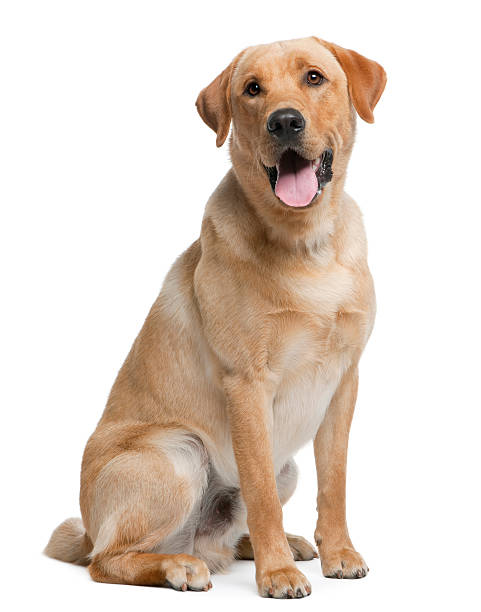

(64, 64, 3)
(1, 64, 64, 3)
1/1 [==============================] - 1s 803ms/step
[[0.00862018 0.99137986]]
1
Predict : dog


In [35]:
image = cv2.imread(testfile)
cv2_imshow(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (64, 64)) # size of picture = [64,64, 3]

print(image.shape)
data = [image] # size of picture arrays = [1,64,64, 3]

data = np.array(data)
print(data.shape)
data = data/255.0


predIdxs = model.predict(data)
print(predIdxs)

result = np.argmax(predIdxs)

print(result)
if result == 0:
  print("Predict : cat")
if result == 1:
  print("Predict : dog")
